In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
from climpred import HindcastEnsemble
import climpred

In [2]:
def decode_cf(ds, time_var):
    if ds[time_var].attrs['calendar'] == '360':
        ds[time_var].attrs['calendar'] = '360_day'
    ds = xr.decode_cf(ds, decode_times=True)
    return ds

In [3]:
# Nino34 box
minlon=190
maxlon=240
minlat=-5
maxlat=5

# Years
yrmin = '1982-01-01'
yrmax = '2010-12-01'

# Months per year
nmpyr=12

In [4]:
# Get NMME data for NCEP-CFSv2, SST
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/NCEP-CFSv2/.HINDCAST/.MONTHLY/.sst/dods'
fullda = decode_cf(xr.open_dataset(url, decode_times=False, chunks={'S': 1, 'L': 12}), 'S')

In [5]:
# Make S (init) Dimension datetime & use first of month for date time step (e.g. Monthly Mean for Jan 1982 is 1982-01-01)
fullda['S']=pd.to_datetime(fullda.S.values.astype(str))
fullda['S']=pd.to_datetime(fullda['S'].dt.strftime('%Y%m01 00:00'))

In [6]:
# Make sure lead is an integer: NMME leads are 0.5, 1.5, 2.5, etc, which correspond to 0, 1, 2, ... months since initialization, I think
fullda['L']=(fullda['L']-0.5).astype('int')

In [7]:
# Rename dimensions for clim pred Hindcast Ensemble object
fcst=fullda.rename({'S': 'init','L': 'lead','M': 'member', 'X': 'lon', 'Y': 'lat'})

In [8]:
# Calculate nino34
fcst=fcst.sel(lat=slice(minlat,maxlat),lon=slice(minlon,maxlon)).mean(['lat','lon'])

In [9]:
# Subset lead, and times
fcst=fcst.sel(init=slice(yrmin,yrmax))

In [10]:
# Make anomalies
fcstclimo = fcst.groupby('init.month').mean('init')
fcstanoms = (fcst.groupby('init.month') - fcstclimo)

In [11]:
# Make Seasonal Averages for model
fcstanoms=fcstanoms.rolling(lead=3, center=True).mean().dropna(dim='lead')
nleads=fcstanoms['lead'][::3].size

In [12]:
# Get verification data
obsurl='http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.OIv2_SST/.sst/dods'
obsda = decode_cf(xr.open_dataset(obsurl, decode_times=False),'T')
obsda['T']=pd.to_datetime(obsda.T.values.astype(str))
obsda['T']=pd.to_datetime(obsda['T'].dt.strftime('%Y%m01 00:00'))

In [13]:
# Rename dimensions for clim pred Hindcast Ensemble object
obs=obsda.rename({'T': 'time','X': 'lon', 'Y': 'lat'})

In [14]:
# Calculate nino34
obs=obs.sel(lat=slice(minlat,maxlat),lon=slice(minlon,maxlon)).mean(['lat','lon'])

In [15]:
# Subset data time
obs=obs.sel(time=slice(yrmin,yrmax))

In [16]:
# Make anomalies
obsclimo = obs.groupby('time.month').mean('time')
obsanoms = obs.groupby('time.month') - obsclimo

In [17]:
# Make Seasonal Averages for obs
obsanoms=obsanoms.rolling(time=3, center=False).mean().dropna(dim='time')

In [18]:
print(fcstanoms)

<xarray.Dataset>
Dimensions:  (init: 348, lead: 8, member: 24)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8
  * member   (member) float32 1.0 2.0 3.0 4.0 5.0 ... 20.0 21.0 22.0 23.0 24.0
  * init     (init) datetime64[ns] 1982-01-01 1982-02-01 ... 2010-12-01
    month    (init) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (init, lead, member) float32 dask.array<chunksize=(1, 8, 24), meta=np.ndarray>


In [19]:
# Create new xarray DataArray with monthly data
fcstanoms2=xr.DataArray(fcstanoms['sst'][:,::3,:], 
                           coords={'init' : fcstanoms['init'],
                                   'lead': np.arange(0,nleads),
                                   'member': fcstanoms['member'],
                                   },
                           dims=['init','lead','member'])
fcstanoms2.name = 'sst'
fcstanoms2['lead'].attrs={'units': 'seasons'}

In [20]:
print(fcstanoms2)

<xarray.DataArray 'sst' (init: 348, lead: 3, member: 24)>
array([[[ 0.08003107,  0.34436545, -0.09682973, ..., -0.0041364 ,
          0.1379687 ,  0.10262489],
        [ 0.60293835,  0.9097843 ,  0.37091127, ...,  0.5670357 ,
          0.9757512 ,  0.42011452],
        [ 1.4331284 ,  1.1431637 ,  0.3319912 , ...,  1.3245068 ,
          1.1187019 ,  0.3438568 ]],

       [[ 0.23546664,  0.6823273 ,  0.3803641 , ...,  0.2140878 ,
         -0.00394758,  0.226916  ],
        [ 0.9181302 ,  0.935414  ,  0.4361731 , ...,  0.04493014,
         -0.07529577,  0.38970247],
        [ 1.8201174 ,  0.47118887,  0.23358662, ...,  0.33039474,
          0.3147119 ,  0.36761728]],

       [[-0.26743445, -0.36520895, -0.09177971, ..., -0.22709274,
         -0.13796806, -0.26382828],
        [-0.4092884 , -0.5334695 ,  0.03718758, ..., -0.57399684,
         -0.2128849 , -0.40550676],
        [-0.1681633 , -0.34384727,  0.82539815, ..., -0.39606032,
          0.43083826, -0.03142611]],

       ...,

     

In [21]:
hindcast = HindcastEnsemble(fcstanoms2)
hindcast = hindcast.add_reference(obsanoms, 'observations')
skillds = hindcast.compute_metric(metric='acc')

Text(0, 0.5, 'Lead Time (Seasons)')

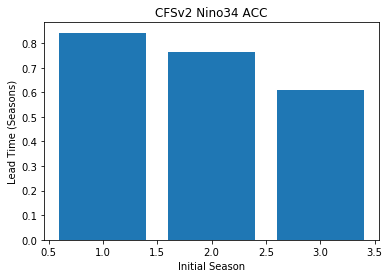

In [25]:
# Plot initial vs. Lead ACC Skill
x=np.arange(1,nleads+1)
plt.bar(x,skillds['sst'])
plt.title('CFSv2 Nino34 ACC')
plt.xlabel('Initial Season')
plt.ylabel('Lead Time (Seasons)')